## What is this?
Experiment to weave nnaudio, timm and fastai together

## What's in this version?
👉 Create transformation function with nnAudio.

👉 Create a custom Transform with fastai.

👉 Check if a custom Dataset can be created using fastai+nnAudio.

## TBD
👉 Dataloader

👉 Learner

👉 Training

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Installing all the required libraries⚙️
👉 Spacy

👉 Fastai

👉 nnAudio

👉 timm

In [2]:
#!pip install spacy==3.1.1

In [3]:
#!yes Y|conda install -c fastai fastai=2.5.2
!pip install fastai==2.5.2

     |████████████████████████████████| 186 kB 808 kB/s 
     |████████████████████████████████| 22.1 MB 7.0 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
     |████████████████████████████████| 831.4 MB 1.1 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.3.20
    Uninstalling fastcore-1.3.20:
      Successfully uninstalled fastcore-1.3.20
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.1
    Uninstalling torchvision-0.8.1:
      Successfully uninstalled torchvision-0.8.1
  Attempting uninstall: fastai
    Found existing installation: fastai 2.2.7
    Uninstalling fastai-2.2.7:
      Successfully uninstalled fastai-2.2.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source

In [4]:
!pip install timm

     |████████████████████████████████| 376 kB 818 kB/s 


In [5]:
!pip install nnaudio

## Import all required modules🖥️

In [6]:
#export
from nnAudio.Spectrogram import CQT
from timm import create_model, list_models
from pandas.core.frame import DataFrame
from fastcore.foundation import *
from fastai.vision.all import *
from fastai.vision.learner import _update_first_layer

## Get the files🏗️
I will try to grab all the numpy files inside train folder

In [7]:
path = Path("../input")

### Get labels🏗️
Training labels are in the 'training_labels.csv' file.

In [8]:
df = pd.read_csv(path/'g2net-gravitational-wave-detection/training_labels.csv')

In [9]:
df.head(1)

,id,target
0,00000e74ad,1


## getfiles(path: Path, ext)
Get numpy files in `path` recursively, only in `folders`, if specified.

> The "#export" in the function below and all the rest of the functions/code are there to help me use nbdev to export the required codes into a library later.

In [10]:
#export
def getfiles(path: Path, ext):
    "Get numpy files in `path` recursively, only in `folders`, if specified."
    return L(path.glob(f'**/*.{ext}'))

In [11]:
train_path = path/'g2net-gravitational-wave-detection/train'

I am using the previous function to get all the files under the train folder.

In [12]:
%%time
train_files = getfiles(train_path, "npy")

CPU times: user 5.94 s, sys: 2.17 s, total: 8.11 s
Wall time: 1min 19s


Just a quick test to see if we got the correct files.

In [13]:
train_files[:2]

(#2) [Path('../input/g2net-gravitational-wave-detection/train/7/7/7/777d746e90.npy'),Path('../input/g2net-gravitational-wave-detection/train/7/7/7/777ecfbd65.npy')]

Picking labels from the dataframe. We may need thes elabels later or we may not.

In [14]:
labels = df.target.to_list()

## Map path to labels🗺️
To make things easier I will try to map the file paths to their respective labels and create a datafrane out of it.

In [15]:
#export
def map_path_to_labels(data: L, cols: L=None ) -> DataFrame:
    """maps the files to their labels"""
    if cols is None: raise ValueError("You forgot to provide the columns")
    data = dict(zip(cols, data))
    return pd.DataFrame.from_dict(data)

In [16]:
%%time
df = map_path_to_labels([train_files, labels], cols=["id", "target"])

CPU times: user 2.31 s, sys: 7.65 ms, total: 2.32 s
Wall time: 2.34 s


In [17]:
df.head(1)

,id,target
0,../input/g2net-gravitational-wave-detection/train/7/7/7/777d746e90.npy,1


Sample out a subset for quick experiment. Here I wil ltake 20,000 samples.

In [18]:
sample = df[:20000]

In [19]:
sample.shape

(20000, 2)

In [20]:
sample.head(1)

,id,target
0,../input/g2net-gravitational-wave-detection/train/7/7/7/777d746e90.npy,1


## Q transform using nnaudio⚗️
We will design a transformstion function that would get the q transform of the time series on the fly using nnaudio.
The result will be similar to converting the time series data into images.

Code taken from [notebook](https://www.kaggle.com/yasufuminakama/g2net-efficientnet-b7-baseline-training) shared by [Y.Nakama](https://www.kaggle.com/yasufuminakama)

In [21]:
#export
def qtfms(o):
    """convert waves to images"""
    waves = np.load(o)
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    cqt = CQT(sr= 2048, fmin= 20, fmax= 1024, hop_length= 32, bins_per_octave=8,verbose=False)
    image = cqt(waves)
    return image

---
**NOTE**

Remember to set `verbose` False if you don't want all the string output to be displayed everytime dataloader loads the data.

---

Quick test to see if this works.

In [22]:
image = qtfms(sample.loc[1, 'id'])
image.shape

/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


torch.Size([1, 46, 385])

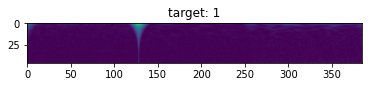

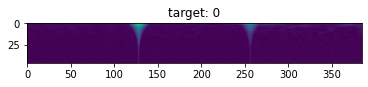

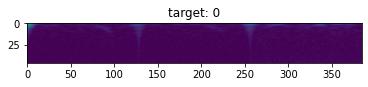

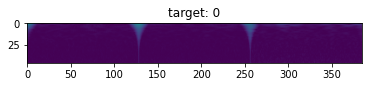

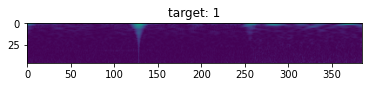

In [23]:
for i in range(5):
    image = qtfms(sample.loc[i, 'id'])
    target = sample.loc[i, 'target']
    plt.imshow(image[0])
    plt.title(f"target: {target}")
    plt.show()

Cool! so we are able to plot the images now. IT is fast too.

## Creating the dataset🖫
If you want to use fastai's learner to train your model on the transfomed spectograms, you can do so by creating a custom Dataset in pytorch and then feeding that dataset with a dataloader to fastai's learner. However, if you create a pipeline using fastai's internals then you get to use some cool functionalities out-of-box. We will see that in a while.

All the code below are very heavily insipired by the original inspiration of this notebook (see the very first section), this [post](https://ohmeow.com/posts/2020/04/11/finding-datablock-nirvana-part-1.html) by Wayde Gilliam and the fastai s[iamese tutorial](https://docs.fast.ai/tutorial.siamese.html#Writing-your-custom-data-block).

In [24]:
sample.loc[1]['id']

Path('../input/g2net-gravitational-wave-detection/train/7/7/7/777ecfbd65.npy')

## NNAudioImage(fastuple)
First of all we are going to create an "Image type" for our transformed object (it's the numpy data transformed into spectogram). We have to do this because our dat ais not an image data from get-go. Rather it's a signal data which we are transforming into an Imgae. So, in order to tell fastai that this is a custom Image type which we are dealing with and ho wwe should be displaying it, we have to create an Image type.

In [25]:
#export
class NNAudioImage(fastuple):
    """Custom Image for nnAudio transformed signals"""
    def show(self, ctx=None, **kwargs):
        img, category = self
        if not isinstance(img, Tensor):
            img_tensor = tensor(img)
        else: 
            img_tensor = img    
        return show_image(img_tensor, title=category, ctx=ctx, **kwargs)

## NNAudioDataset
One of the way to create a Dataset in fastai is to create a custom transform by inheriting from the `Transform` class. Creating a `Transform` has come advantages as compared to a pytorch Dataset like you don't need to have a `len` component or a `get_item` component.

On a very high level a `Transform` has an `encodes`, `decodes` and `setup` methods. For our purpose having an `encodes` methods only would suffice. This is the place where we would be transforming the numpy data into spectograms.

To know more about `Tranforms` refer these -->
* [data block nirvana](https://ohmeow.com/posts/2020/04/11/finding-datablock-nirvana-part-1.html)
* [Siamese tutorial](https://docs.fast.ai/tutorial.siamese.html#Writing-your-custom-data-block)
* [Fastbook chapter-11](https://github.com/fastai/fastbook/blob/master/11_midlevel_data.ipynb)

In [26]:
#export
class NNAudioTransform(Transform):
    """Custom Transform which uses nnAudio transforms
    to extract spectogram on the fly"""
    def __init__(self, df, x_col:str, y_col: str):
        self.df = df
        self.x_col = x_col
        self.y_col = y_col

    def encodes(self, img_path):
        label = self.df[self.df[self.x_col] == img_path][self.y_col].values[0]
        img = qtfms(img_path)
        #img = img.squeeze().numpy()
        return NNAudioImage(img, label)

Look how we can use the `NNAudioImage` class to tell fastai Transform about the type of data which we want to get.

Now that we have a transform, we will use an object known as `TfmdLists` to create our Dataset. 
> A `TfmdLists` lazily applies all our transforms to our a list of items. 

We will also use a 'splitter' which tells fastai the way we want to split our data. For now we will use `RandomSplitter` to do this job. Additionally we will also instantiate the `NNAudioTransform` object.

In [27]:
splits = RandomSplitter()(sample.id.to_list())
tfm = NNAudioTransform(sample,'id', 'target')

Next, we have to tell fastai to take our 'sample' and apply the transform and the splitter to it.

In [28]:
tls = TfmdLists(sample.id.to_list(), tfm, splits=splits)

Now that we have a Dataset in place, we can grab an item out of it and view it by using `show_at` method.

<AxesSubplot:title={'center':'1'}>

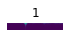

In [29]:
show_at(tls.train, 1)

Let's plot with vanialla matplotlib to check if we get the same image.

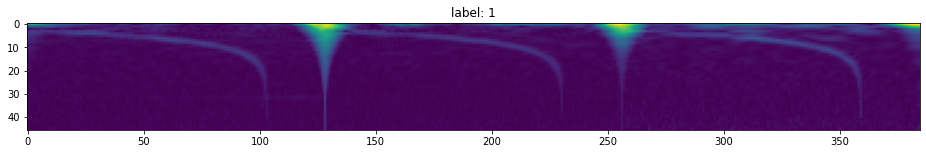

In [30]:
plt.figure(figsize=(16,12))
image,label = tls.train[0]
plt.imshow(image[0])
plt.title(f'label: {label}')
plt.show() 

So, we are all good. We can now create a custom fastai Dataset and display the data in it.

## Create the Dataloader🖨️
We can use the `TfmdLists` to create a dataloader by calling `dataloaders()`. Here we can't apply `item_tfms` or `batch_tfms` but we can get the hooks to different point in time of the pipeline and can put our transforms there.

For example, once items are grabbed then that moment is known as "after_item". We can use this hook to apply our transforms once items are grabbed.

In [31]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], bs=64)

One more thing that we need to do is to make the `show_batch` method aware of the type of our Image. This can be easily done by using `typedispatch` to dispatch our `show_batch` (the one which we will override with our image type). 

In [32]:
#export
@typedispatch
def show_batch(x:NNAudioImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=3, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        NNAudioImage(x[0][i], x[1][i].item()).show(ctx=ctx)

`typedispatch` does somethign similar to [multi-dispatch](https://en.wikipedia.org/wiki/Multiple_dispatch). So, that whenever we call the `show_batch` on our image type then fastai will call our version of `show_batch` after recognizing our image type.

Here we go

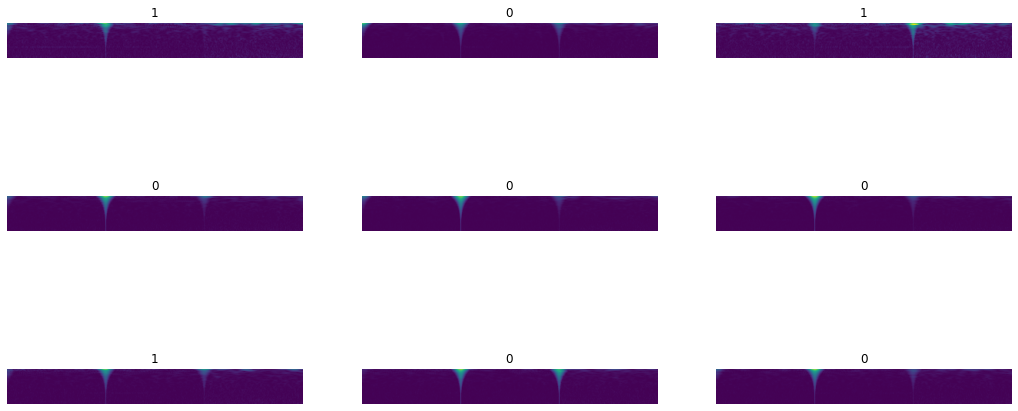

In [33]:
dls.show_batch()

## Make your own model🍕
We are going to use the timm library as the source of our model. To weave it into fastai, we will create a custom fastai model.

All the code below is heavily inspired by-->

* [Ayushman's](https://www.kaggle.com/benihime91) [notebook](https://www.kaggle.com/benihime91/fastai-timm-efficientnet-train-fold-0).
* fastai siamese [tutorial](https://docs.fast.ai/tutorial.siamese.html).

We will also take into account the structure of fastai's `create_cnn_model` class. The code for which is as follows

In [34]:
create_cnn_model??

Let's build our own.

We will cut off the head of a timm pretrained model using `create_body` and take the encoder only as this would be the portion of the pretrained model which I would like to use. Then I will top it off with a custom fastai head using `create_head` that we would need to train on our target data.

To know more about this flow have a look into the fastai siamese [tutorial](https://docs.fast.ai/tutorial.siamese.html).

But first we will create our custom `create_body` and `create_head` functions. the reason for this is that fastai in it's current state is not integrated with the timm library. So, creating custom versions of `create_body` and `create_head` makes the weaving of timm into fastai re-usable.

The insipration for this is the [post](https://walkwithfastai.com/vision.external.timm#create_timm_body) in 'walk with fastai'. Once again the code and teh approach is heavily based on this post.

> I am recreating this again here instead of using the 'walk with fastai' library is to drill down into the concept and for my personal learning.

## create_timm_body

In [35]:
#export
def create_timm_body(arch, n_in=3, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained timm library `arch` as determined by `cut`"
    model = create_model(arch, pretrained=pretrained, num_classes=0, in_chans=1,global_pool='')
    _update_first_layer(model, n_in, pretrained)
    #cut = ifnone(cut, cnn_config(arch)['cut'])
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int):      return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else:  raise NamedError("cut must be either integer or a function")

Now that we have a way to create a body, we will use the code from `create_cnn_model` to build our custom `create_timm_model`.

The code for `create_timm_model` is as follows.

In [36]:
create_cnn_model??

## create_timm_model

In [37]:
create_head?

In [38]:
#export
@delegates(create_head)
def create_timm_model(arch, n_out, pretrained=True, cut=None, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, in_chans=1, **kwargs):
    "Create custom architecture from the timm library"
    body = create_timm_body(arch, n_in, pretrained, None)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

The `@delegate` macro tells fastai to show the parameters of any `**kwargs` (which we would be using in the `create_body`) during function [introspection](https://fastcore.fast.ai/meta.html#delegates).

Let's do a quick test to check if our custom model works.

In [39]:
# num of classes
n_out = 2

In [40]:
model = create_timm_model("efficientnet_b3a", n_out)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


In [41]:
L(model.children())

(#2) [Sequential(
  (0): Conv2d(1, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
  (3): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (

cool! so it works.

Now, we will build a learner which would enable us to do transfer learning with timm models. Once again we will port `cnn_learner` for our use and like before let's quickly take a look into the `cnn_learner` code

In [42]:
cnn_learner??

In [43]:
#export
@delegates(create_timm_model)
def timm_learner(dls, arch, n_out=None, pretrained=True,
                # learner args
                loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
                model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
                # other model args
                **kwargs):
    "Build a convnet style learner from `dls` and `timm arch`"

    kwargs = {**kwargs}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    model = create_timm_model(arch, n_out, default_split, pretrained, **kwargs)

    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=default_split, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn,
                   moms=moms)
    if pretrained: learn.freeze()
    # keep track of args for loggers
    store_attr('arch,n_out,pretrained', self=learn, **kwargs)
    return learn

Here we go we somehow managed to get a port of the learner code which looks the part. Does it work?

Let me find out.

> To find the list of models available in the timm library use `list_models`

In [44]:
list_models("efficient*")

['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_s']

## The learner👩‍🏫
Now that we have the model in place, we can go ahead and create the learner the usual way. We have kept the batch size to default.

There is one little thing that I would like to do before creating learner. I will create a helper function which can help me to get the suggested learning rate quickly.

In [45]:
#export
def show_me_lrs(learn):
    suggestions = namedtuple('Suggestions', ["min", "steep",
                                            "valley", "slide"])
    lr_min, lr_steep,lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep,valley, slide))
    suggested_lrs = suggestions(lr_min, lr_steep, lr_valley, lr_slide)
    
    print(f"Minimum/10:\t{lr_min:.2e}\
          \nSteepest point:\t{lr_steep:.2e}\
          \nLongest valley:\t{lr_valley:.2e}\
          \nSlide interval:\t{lr_slide:.2e}")
    
    return suggested_lrs

In [46]:
learn = timm_learner(dls, 'efficientnet_b7', loss_func=CrossEntropyLossFlat(), metrics=[RocAucBinary(axis=0)], n_out=2).to_fp16()

Fit one epoch to see how it behaves

In [47]:
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.809027,0.776363,0.487233,09:27


Using the learnign rate finder to get the learning rate

In [48]:
learn.unfreeze()

/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	2.29e-05          
Steepest point:	2.75e-06          
Longest valley:	3.98e-04          
Slide interval:	5.25e-03


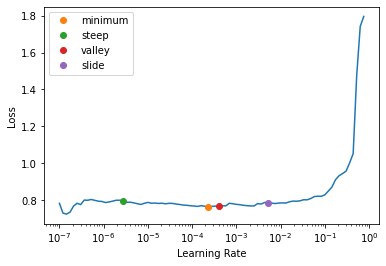

In [49]:
suggested_lrs = show_me_lrs(learn)

I will use the slide algorithm here to get the optimal learning rate.

In [50]:
learn.fit_one_cycle(5, lr_max=suggested_lrs.slide)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.817600,2.180261,0.497700,09:24
1,0.822535,0.886126,0.506089,09:30
2,0.798694,0.698949,0.494648,09:28
3,0.786659,0.705695,0.498027,09:28
4,0.749765,0.693733,0.521068,09:27


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudi

In [51]:
learn.export("./final")

## TBD🎈🎈
👉 How does the perfromance changes with data augmentation?

👉 Does data augmentation in the context of gravitation signals somehow mutatet the data ? is it good?

👉 How about transformations other than CQT?

👉 How about introducing pre-processing. Maybe some form of cleaning of the signals?
